## Tropical cyclone swaths and impacts on coastal areas

This workflow calculates areas of different coastal buffers and then calculates the areas of tree cover loss (according to Global Forest Watch) that have occured within these different coastal buffers.  

Note the following are customisable parameters:

1. country boundary - updated in cell 2
2. bbox - updated in cell 2
3. TC data - updated in cell 2 and across several other cells
4. buffer_width - in cell 10
5. TC year - updated in cells 28 and 38 

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.features import rasterize
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import rioxarray
from shapely.geometry import box
from rasterio.features import shapes
from shapely.geometry import shape  # Ensure this is imported
import numpy as np

### Plot areas of coastal buffers

Using Government Administration Boundaries (GADM) and then calculating buffer areas.

In [2]:
fiji = gpd.read_file("fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")
bbox = gpd.read_file("bbox_fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")
Harold_64kn = gpd.read_file("swaths/Harold_FJ_64kn.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")

/tmp/ipykernel_2571/4404331.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bbox = gpd.read_file("bbox_fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")
/tmp/ipykernel_2571/4404331.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Harold_64kn = gpd.read_file("swaths/Harold_FJ_64kn.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")


In [3]:
Harold_64kn = Harold_64kn.geometry.buffer(0)

In [4]:
fiji = gpd.clip(fiji, bbox)
Harold_64kn = gpd.clip(Harold_64kn, bbox)

<Axes: >

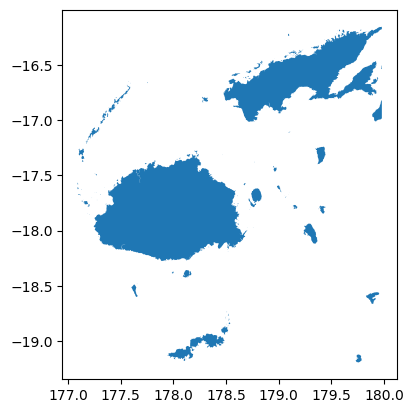

In [5]:
fiji.plot()

Setup ring buffers

<Axes: >

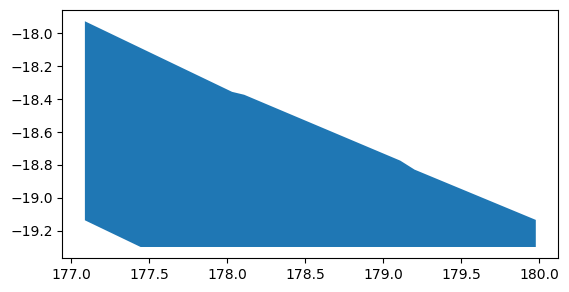

In [6]:
Harold_64kn.plot()

<Axes: >

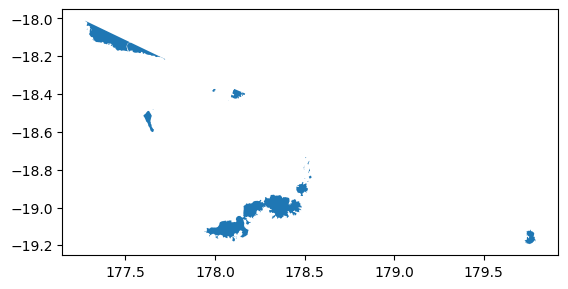

In [7]:
Harold_vu = gpd.clip(fiji, Harold_64kn)
Harold_vu.plot()

In [8]:
Harold_vu = Harold_vu.to_crs("EPSG:32760")

In [9]:
fiji = fiji.to_crs("EPSG:32760")

In [10]:
buffer_width = -1000

In [11]:
buffer = Harold_vu.buffer(buffer_width)

In [12]:
ring_buffer = buffer.symmetric_difference(Harold_vu, align=True)

<Axes: >

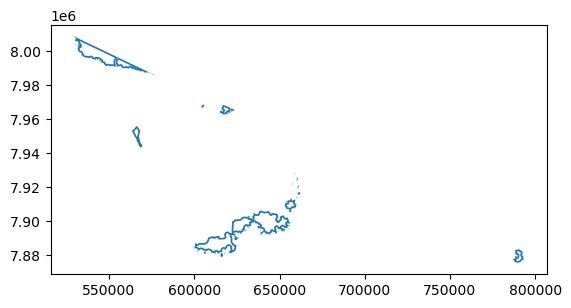

In [13]:
ring_buffer.plot()

In [14]:
fiji = fiji.buffer(buffer_width)

In [15]:
ring_buffer = ring_buffer.difference(fiji, align=True)

In [16]:
difference_polygon = ring_buffer.geometry[0].difference(fiji.geometry[0])

In [17]:
buffer = gpd.GeoDataFrame({'geometry': [difference_polygon]}, crs=fiji.crs)

In [18]:
print(buffer.geometry.area)

0    3.776189e+08
dtype: float64


In [19]:
polygon = buffer.geometry[0]

In [20]:
# Flatten to a single Polygon
flattened_polygon = unary_union(polygon)

In [21]:
buffer = gpd.GeoDataFrame(geometry=[flattened_polygon], crs="EPSG:32760")  # Adjust CRS as needed

<Axes: >

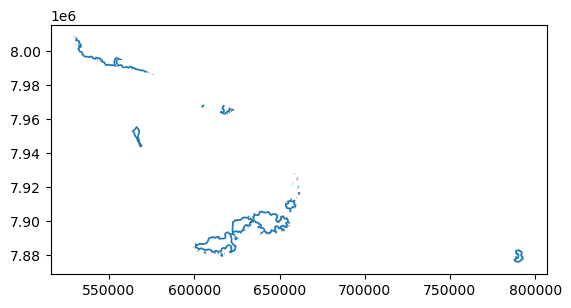

In [22]:
buffer.plot()

In [23]:
buffer_area = buffer.to_crs("EPSG:32760")
# buffer_area = buffer_area.area.geometry

In [24]:
# Calculate area (returns a Series)
areas = buffer_area.geometry.area

# If you need the total area
total_area_buffer = areas.sum()

print(f"Total Area: {total_area_buffer} square meters")


Total Area: 377618916.97773343 square meters


In [25]:
print(total_area_buffer/1000000)

377.6189169777334


### Plot areas of coastal buffers

Calculating areas of tree cover loss (GFW) datasets:

In [26]:
raster_path = "GFW/LossYear_GFW_Fiji.tif"

CRS: EPSG:4326
Bounds: BoundingBox(left=176.78846280169938, bottom=-19.371546897773065, right=181.86439331461673, top=-15.95920645951665)


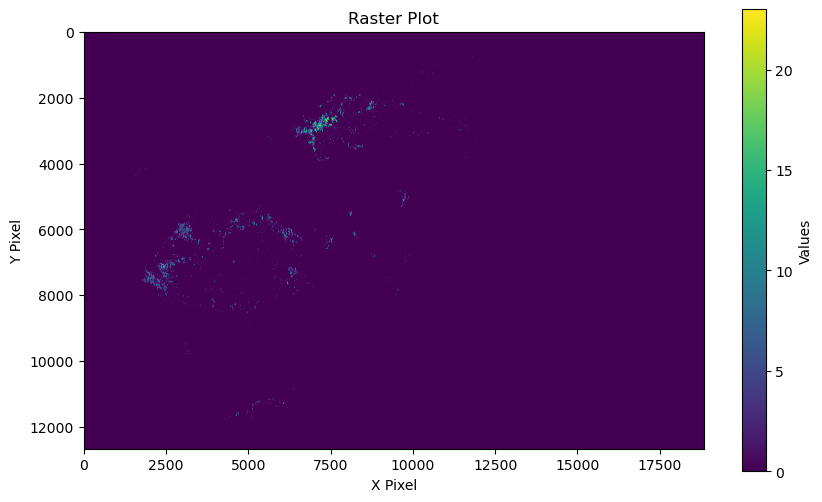

In [27]:
with rasterio.open(raster_path) as src:
    # Read the raster's first band
    data = src.read(1)  # Reads the first band (use src.read() for all bands)
    crs = src.crs
    bounds = src.bounds
    print("CRS:", crs)
    print("Bounds:", bounds)

# Plot the raster
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='viridis')  # Change cmap for different color maps
plt.colorbar(label="Values")
plt.title("Raster Plot")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

In [28]:
import rasterio
import numpy as np

# Path to the input raster and the output raster
input_raster_path = "GFW/LossYear_GFW_Fiji.tif"
output_raster_path = "GFW/GFW_TC_Harold_2016.tif"

# The specific value you want to extract
specific_value = 20

# Open the input raster file
with rasterio.open(input_raster_path) as src:
    # Read the data for the first band (you can modify for multi-band raster)
    band = src.read(1)  # Read the first band
    
    # Ensure no-data value is valid for the raster's data type
    dtype = band.dtype
    if dtype == np.uint8:
        custom_nodata = 255  # Valid no-data value for uint8
    else:
        custom_nodata = -9999  # Default for other data types
    
    # Create a mask where the value matches the specific value
    mask = band == specific_value
    
    # Replace the non-matching values with the custom no-data value
    band[~mask] = custom_nodata  # Set all other pixels to custom no-data value
    
    # Copy the metadata from the source raster
    metadata = src.meta
    
    # Update the metadata to reflect that the new raster is single-band
    metadata.update(count=1, nodata=custom_nodata)

    # include crs
    crs = "EPSG:32760"
    
    # Create and write the new raster file with the filtered values
    with rasterio.open(output_raster_path, 'w', **metadata) as dst:
        dst.write(band, 1)  # Write the modified data (filtered)

print(f"New raster created: {output_raster_path}")


New raster created: GFW/GFW_TC_Harold_2016.tif


In [29]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          60G  9.8G   51G  17% /
tmpfs            64M     0   64M   0% /dev
tmpfs            32G     0   32G   0% /sys/fs/cgroup
/dev/nvme1n1    9.8G  8.1G  1.7G  83% /home/jovyan
/dev/nvme0n1p1   60G  9.8G   51G  17% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs            62G   12K   62G   1% /run/secrets/kubernetes.io/serviceaccount
tmpfs            62G  4.0K   62G   1% /run/secrets/eks.amazonaws.com/serviceaccount
tmpfs            32G     0   32G   0% /proc/acpi
tmpfs            32G     0   32G   0% /sys/firmware


In [30]:
# Open the raster data
with rasterio.open(raster_path) as src:
    # Get the raster's data as an array
    image = src.read(1)  # Read the first band
    # include crs
    crs = "EPSG:4326"
    
    # Extract shapes from the raster
    # 'transform' will be used to convert pixel coordinates into spatial coordinates
    results = shapes(image, mask=None, transform=src.transform)

    # Create a list of geometries and associated values from the results
    geometries = []
    for geom, value in results:
        geometries.append({"geometry": shape(geom), "value": value})
# Convert the list of geometries into a GeoDataFrame
gdf = gpd.GeoDataFrame(geometries)

In [31]:
gdf = gdf.set_crs("EPSG:4326")

<Axes: >

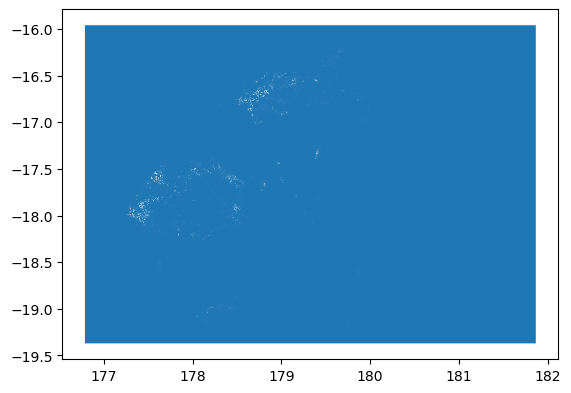

In [32]:
gdf.plot()

In [33]:
gdf.to_file("test_fiji.geojson")

In [34]:
# gdf.to_crs("EPSG:32760")
if gdf.crs is None:
    gdf.set_crs("EPSG:4326", inplace=True)  # Replace 'XXXX' with the correct CRS


In [35]:
# Ensure the GeoDataFrame contains Polygon geometries
# Here, we assume that the first geometry in the GeoDataFrame is a Polygon.
polygons = gdf.geometry.tolist()

polygons = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].geometry.tolist()
multipolygon = MultiPolygon(polygons)


In [36]:
# if filter_column not in gdf.columns:
#     raise ValueError(f"Column '{filter_column}' does not exist in the GeoDataFrame.")


In [37]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Ensure the GeoDataFrame contains valid Polygon geometries
polygons = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].geometry.tolist()

# Convert to a MultiPolygon
multipolygon = MultiPolygon(polygons)

# Create a new GeoDataFrame with the MultiPolygon
multipolygon_gdf = gpd.GeoDataFrame({'geometry': [multipolygon]})


In [38]:

# Set the CRS (ensure it matches gdf or set explicitly if missing)
if gdf.crs is None:
    gdf.set_crs("EPSG:4326", inplace=True)  # Replace with the correct CRS
multipolygon_gdf.set_crs(gdf.crs, inplace=True)

# Validate geometries
multipolygon_gdf["geometry"] = multipolygon_gdf.geometry.buffer(0)

# Specify the column and the specific value to filter
filter_column = "value"  # Column with the values
specific_value = 20  # Replace with the value you want to extract


In [39]:

# Ensure the filter column exists
if filter_column not in gdf.columns:
    raise ValueError(f"Column '{filter_column}' does not exist in the GeoDataFrame.")

# Filter the GeoDataFrame for the specific value
filtered_gdf = gdf[gdf[filter_column] == specific_value]

# Transform CRS if necessary
filtered_gdf = filtered_gdf.to_crs("EPSG:4326")


In [40]:
import os

if os.path.exists("filtered_polygons.gpkg"):
    os.remove("filtered_polygons.gpkg")

filtered_gdf.to_file("filtered_polygons.gpkg", driver="GPKG")



### Calculate areas of overlap between coastal buffers and tree cover loss for the year of the tropical cyclone event: 

Calculate areas of intersection:

In [41]:
filtered_gdf = filtered_gdf.set_crs("EPSG:4326")
# filtered_gdf.to_file("test-filtered.geojson")

In [42]:
buffer = buffer.to_crs("EPSG:4326")
buffer.to_file("test-fiji-buffer.geojson")

In [43]:
intersection_exists = buffer.geometry.intersects(filtered_gdf.unary_union).any()
print("Do they intersect?", intersection_exists)

/tmp/ipykernel_2571/3829474141.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersection_exists = buffer.geometry.intersects(filtered_gdf.unary_union).any()


Do they intersect? True


In [44]:
clipped_gdf = gpd.clip(filtered_gdf, buffer)

<Axes: >

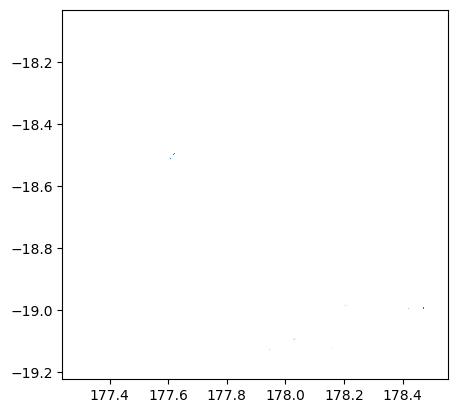

In [45]:
clipped_gdf.plot()

In [46]:
clipped_gdf.to_file("clipped.geojson")

In [47]:
clipped_gdf = clipped_gdf.to_crs("EPSG:32760")

In [48]:
area_gfw = clipped_gdf.geometry.area

In [49]:
total_area_gfw = area_gfw.sum()
print(total_area_gfw, "m2 tree cover loss") 

1541005.7996373198 m2 tree cover loss


In [50]:
percentage_area = (total_area_gfw/total_area_buffer*100)
# percentage_area

In [51]:
# print(total_area_gfw, "m2 tree cover loss")

In [52]:
print(total_area_gfw/1000000, "km2 tree cover loss")

1.5410057996373197 km2 tree cover loss


In [53]:
total_area_gfw = total_area_gfw/1000000

In [54]:
# print(total_area_buffer, "m2 buffer")

In [55]:
total_buffer = (total_area_buffer/1000000)

In [56]:
total_buffer

377.6189169777334

In [57]:
print(percentage_area, "%")

0.4080849052718898 %


In [58]:
# Create a DataFrame with at least one row
results = pd.DataFrame({"id": [1]})  # Add any identifying or dummy data


In [59]:
results['total_buffer_km2']=total_buffer
results['buffer_gfw_km2']=total_area_gfw

In [60]:
results

,id,total_buffer_km2,buffer_gfw_km2
0,1,377.618917,1.541006
